In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from hydra import initialize, compose
from rdkit import Chem

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score
)

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

mlflow.set_tracking_uri(f"file://{cfg.mlruns}")

In [3]:
experiment_name = "Default"
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment:
    df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
else:
    print(f"Experiment '{experiment_name}' not found.")

In [4]:
df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_auroc,metrics.test_acc,metrics.train_loss,metrics.epoch,...,params.model/batch_size,params.study_name,params.training/max_epochs,params.model/pred_head_d_hs,tags.mlflow.source.name,tags.mlflow.source.git.commit,tags.mlflow.runName,tags.source,tags.mlflow.user,tags.mlflow.source.type
0,ad95728f888c44b3bdabbc5a444b235a,381927388217940533,FINISHED,file:///home/stef/cgr/artifacts/mlruns/3819273...,2025-05-12 20:55:58.546000+00:00,2025-05-12 20:56:00.321000+00:00,0.840224,0.504348,1.108007,3.0,...,64,outer_split_0_strategy_random_rule_split_obj_v...,3,None,/home/stef/cgr/scripts/train.py,817533fcc880550018c9fd83b0367b3c1a7e014d,gaudy-turtle-5,train.py,stef,LOCAL


In [5]:
df.sort_values(
    by=["metrics.test_loss"],
    ascending=True,
    inplace=True,
)
df[[*[col for col in df.columns if col.startswith("metrics.") or col.startswith("params.")]]].head(10)

,metrics.test_auroc,metrics.test_acc,metrics.train_loss,metrics.epoch,metrics.test_loss,metrics.test_recall,metrics.test_auprc,metrics.test_precision,params.final_lr,params.use_study,...,params.max_lr,params.data/inner_splitter/_target_,params.model/mp_d_h,params.training/final_lr,params.data/inner_splitter/random_state,params.data/inner_splitter/shuffle,params.model/batch_size,params.study_name,params.training/max_epochs,params.model/pred_head_d_hs
0,0.840224,0.504348,1.108007,3.0,1.038574,0.968354,0.408202,0.183894,0.0001,False,...,0.001,sklearn.model_selection.GroupKFold,300,0.0001,1234,True,64,outer_split_0_strategy_random_rule_split_obj_v...,3,None


In [6]:
row = df.iloc[0]
run_id = row.run_id
experiment_id = row.experiment_id

In [7]:
pred_df = pd.read_parquet(
    Path(row.artifact_uri.replace("file://", "")) / "predictions.parquet"
)
pred_df.head()

,rxn_id,aidx,y,y_pred
0,1,0,0.0,0.509616
1,1,1,0.0,0.567754
2,1,2,0.0,0.536681
3,1,3,0.0,0.602565
4,1,4,0.0,0.540450


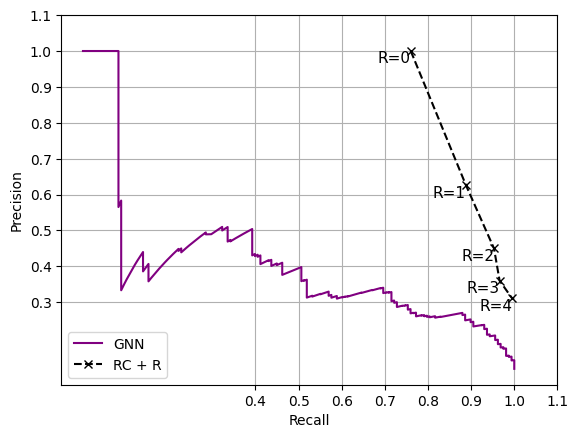

In [8]:
# RC + R stats
recall_from_rcr = [0.76, 0.888, 0.953, 0.966, 0.995]
precision_from_rcr = [1.0, 0.626, 0.450, 0.360, 0.311]
r_labels = [f"R={i}" for i in range(len(recall_from_rcr))]

precision, recall, thresholds = precision_recall_curve(pred_df.y, pred_df.y_pred)
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple', label="GNN")
ax.plot(recall_from_rcr, precision_from_rcr, ls='--', marker="x", color='black', label="RC + R")
ax.set_xticks(np.arange(0.4, 1.15, 0.1))
ax.set_yticks(np.arange(0.3, 1.15, 0.1))
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
for r, p, label in zip(recall_from_rcr, precision_from_rcr, r_labels):
    ax.text(r, p, label, fontsize=11, ha='right', va='top', color='black')
ax.grid()
ax.legend(loc='lower left')
plt.show()